In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

from lsc import LangevinSparseCoding
from utils import KLDivergence

In [52]:
n_features = 2
n_latent = 2
sparsity_penalty = 0
temperature = 1
dt = 1e-2

C = lambda s: s.abs().sum()
Cprime = lambda s: torch.sign(s)

lsc = LangevinSparseCoding(
    n_features=n_features,
    n_latent=n_latent,
    sparsity_penaly=sparsity_penalty,
    temperature=temperature,
    dt=dt,
    cost_function=C,
    cost_function_grad=Cprime
)

lsc.A = torch.tensor([[1., 0.], [0., 1.]])
s_star = torch.ones([n_latent,],dtype=torch.float)

NOISE_MEAN, NOISE_VARIANCE = 0 , 0.1
x = lsc.A@s_star + np.random.normal(NOISE_MEAN, NOISE_VARIANCE) # Additive Gaussian Noise

In [53]:
tmax = int(1e5)

s_inference = torch.ones_like(s_star) #Change to L0
# s_inference = th.zeros_like(s) #Change to L0
energies = []
S = []
S.append(s_inference.data.numpy().copy())
for n in tqdm(range(tmax)):

    energies.append(lsc.energy(x,s_inference).item())
    s_inference += torch.clone(lsc.first_order_langevin_update(x,s_inference))
    S.append(s_inference.data.numpy().copy())
S = np.asarray(S)
energies = np.asarray(energies)

100%|██████████| 100000/100000 [00:03<00:00, 27444.41it/s]


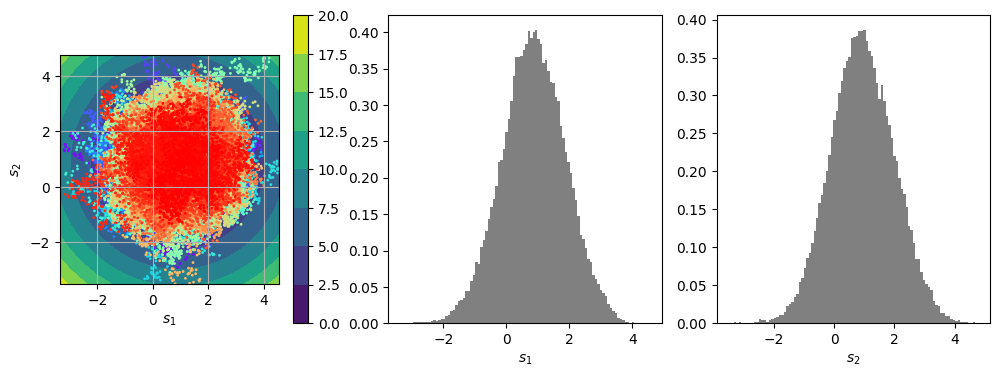

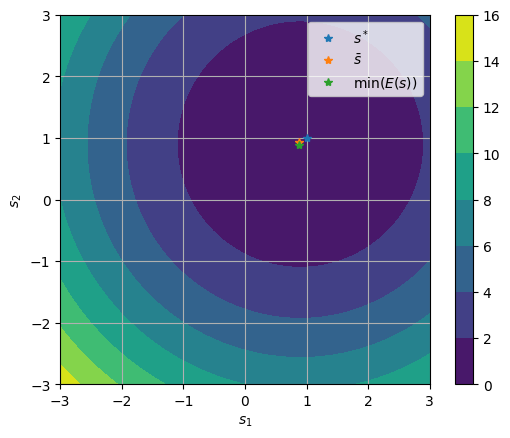

In [54]:
xlist = np.linspace(S[:,0].min(), S[:,0].max(), 100)
ylist = np.linspace(S[:,1].min(), S[:,1].max(), 100)
X, Y = np.meshgrid(xlist, ylist)
Sgrid = np.asarray([X.flatten(),Y.flatten()]).T

Z = np.zeros([Sgrid.shape[0]])
for i in range(len(Z)):
  Z[i] = lsc.energy(x,torch.tensor(Sgrid[i,:],dtype=torch.float))

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
levels = np.asarray([1,5,10,20,40,100])
cp = axes[0].contourf(X, Y, Z.reshape(X.shape)) #,levels)
fig.colorbar(cp) # Add a colorbar to a plot"
colors = cm.rainbow(np.linspace(0, 1, S.shape[0]))
axes[0].scatter(*S.T, color=colors, s=1)
# axes[0].plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
# axes[0].plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
axes[0].set_aspect('equal')
axes[0].set_xlabel(r'$s_1$')
axes[0].set_ylabel(r'$s_2$')
axes[0].grid()
# axes[0].scatter(s.detach().cpu().numpy()[0],s.detach().cpu().numpy()[1],'*',s=10)


axes[1].hist(S[:, 0], fc='grey', bins=100, density=True)
# axes[1].plot(s_, p_, 'r--')
axes[1].set_xlabel(r'$s_1$')

axes[2].hist(S[:, 1], fc='grey', bins=100, density=True)
# axes[2].plot(s_, p_, 'g--')
axes[2].set_xlabel(r'$s_2$')
# plt.suptitle(rf'$dt = {dt:.2f} M^{{-1}}$ ; $T = {TAU_SCALE} \mu^{{-1}}$')
# plt.savefig(f'{TAU_SCALE}_{DT_SCALE}.pdf')
plt.show()

# plot the energy function on a smaller scale 
vmax=3
fig,ax = plt.subplots()
xlist = np.linspace(-vmax, vmax, 100)
ylist = np.linspace(-vmax, vmax, 100)
X, Y = np.meshgrid(xlist, ylist)
Sgrid = np.asarray([X.flatten(),Y.flatten()]).T

Z = np.zeros([Sgrid.shape[0]])
for i in range(len(Z)):
  Z[i] = lsc.energy(x,torch.tensor(Sgrid[i,:],dtype=torch.float))

cp = ax.contourf(X, Y, (Z.reshape(X.shape)))#,levels)
fig.colorbar(cp) # Add a colorbar to a plot
# ax.plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
# ax.plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
q = s_star.unsqueeze(0).detach().cpu().numpy().T

ax.plot(*q,'*',label=r'$s^*$')
ax.plot(*S.mean(axis=0,keepdims=True).T,'*',label=r'$\bar{s}$')
ax.plot(*Sgrid[(np.argmin(Z),),:].T,'*',label=r'$\min(E(s))$')
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.set_aspect('equal')
ax.legend()
ax.grid()

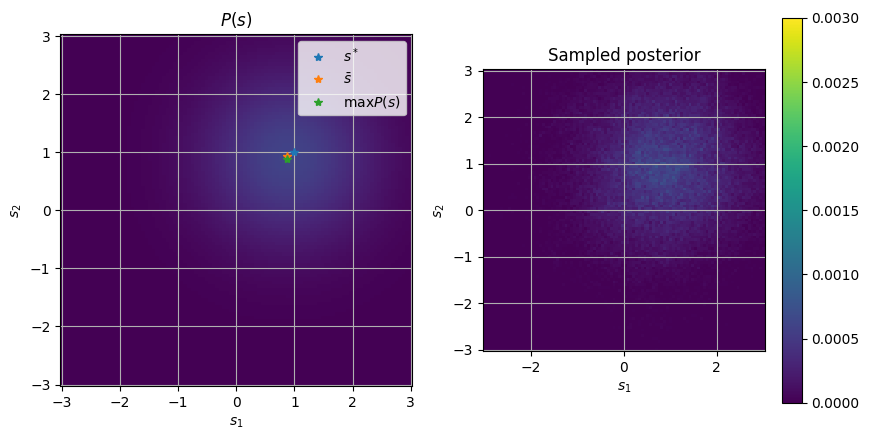

In [55]:
# plot the energy function on a smaller scale 
vmax=3
n_bins=100

fig,axs = plt.subplots(1,2,figsize=(10,5))
xlist = np.linspace(-vmax, vmax, n_bins)
ylist = np.linspace(-vmax, vmax, n_bins)
X, Y = np.meshgrid(xlist, ylist)
Sgrid = np.asarray([X.flatten(),Y.flatten()]).T

Z = np.zeros([Sgrid.shape[0]])
for i in range(len(Z)):
  Z[i] = lsc.p(x,torch.tensor(Sgrid[i,:],dtype=torch.float))
pS_energy_function = Z.reshape(X.shape)
pS_energy_function /= np.sum(pS_energy_function)

ax = axs[0]
cp = ax.pcolormesh(X, Y, pS_energy_function, vmax=3e-3,vmin=0)#,levels)
# fig.colorbar(cp) # Add a colorbar to a plot
# ax.plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
# ax.plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
q = s_star.unsqueeze(0).detach().cpu().numpy().T

ax.plot(*q,'*',label=r'$s^*$')
ax.plot(*S.mean(axis=0,keepdims=True).T,'*',label=r'$\bar{s}$')
ax.plot(*Sgrid[(np.argmax(Z),),:].T,'*',label=r'$\max P(s)$')
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.set_aspect('equal')
ax.legend()
ax.grid()
ax.set_title(r'$P(s)$')

pS_emperical, xedges, yedges = np.histogram2d(
    x=S[:,0],
    y=S[:,1],
    bins=n_bins,
    range=[[-vmax, vmax], [-vmax, vmax]],
    density=True,
)
pS_emperical = pS_emperical.T
pS_emperical /= np.sum(pS_emperical)

ax = axs[1]
cp = ax.pcolormesh(X, Y, pS_emperical,vmax=3e-3,vmin=0)
fig.colorbar(cp)
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.grid()
ax.set_title(r'Sampled posterior')
ax.set_aspect('equal')

In [26]:
print(KLDivergence(pS_emperical.flatten(),pS_energy_function.flatten()))

0.047434159184742024


In [56]:
# sweep through sparsity values

sparsity_pentalty_list = np.linspace(0,6,20)
tmax = int(1e5)
vmax=3
n_bins=100

kl_values = np.empty_like(sparsity_pentalty_list)

for j in tqdm(range(len(sparsity_pentalty_list))):

    lsc.sparsity_penaly = sparsity_pentalty_list[j]

    s_inference = torch.ones_like(s_star) #Change to L0
    # s_inference = th.zeros_like(s) #Change to L0
    energies = []
    S = []
    S.append(s_inference.data.numpy().copy())
    for n in (range(tmax)):

        energies.append(lsc.energy(x,s_inference).item())
        s_inference += torch.clone(lsc.first_order_langevin_update(x,s_inference))
        S.append(s_inference.data.numpy().copy())
    S = np.asarray(S)
    energies = np.asarray(energies)

    # compute true pdf
    xlist = np.linspace(-vmax, vmax, n_bins)
    ylist = np.linspace(-vmax, vmax, n_bins)
    X, Y = np.meshgrid(xlist, ylist)
    Sgrid = np.asarray([X.flatten(),Y.flatten()]).T

    Z = np.zeros([Sgrid.shape[0]])
    for i in range(len(Z)):
        Z[i] = lsc.p(x,torch.tensor(Sgrid[i,:],dtype=torch.float))
    pS_energy_function = Z.reshape(X.shape)
    pS_energy_function /= np.sum(pS_energy_function)

    # compute emperical pdf
    pS_emperical, xedges, yedges = np.histogram2d(
        x=S[:,0],
        y=S[:,1],
        bins=n_bins,
        range=[[-vmax, vmax], [-vmax, vmax]],
        density=True,
    )
    pS_emperical = pS_emperical.T
    pS_emperical /= np.sum(pS_emperical)

    kl_values[j] = KLDivergence(pS_emperical.flatten(),pS_energy_function.flatten())

100%|██████████| 20/20 [01:18<00:00,  3.91s/it]


Text(0.5, 1.0, '$dt=1.0e-02$')

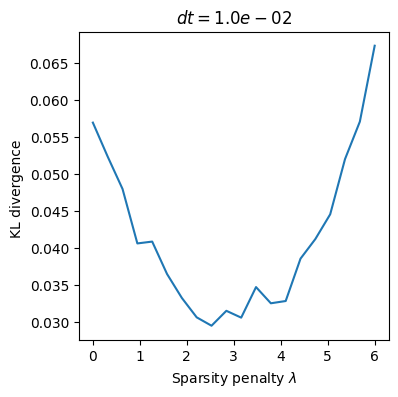

In [57]:
fig,ax = plt.subplots(figsize=(4,4))

ax.plot(sparsity_pentalty_list,kl_values)
ax.set_xlabel(r'Sparsity penalty $\lambda$')
ax.set_ylabel(r'KL divergence ')
ax.set_title(r'$dt=%.1e$'%(dt))

Text(0.5, 1.0, '$dt=1.0e-01$')

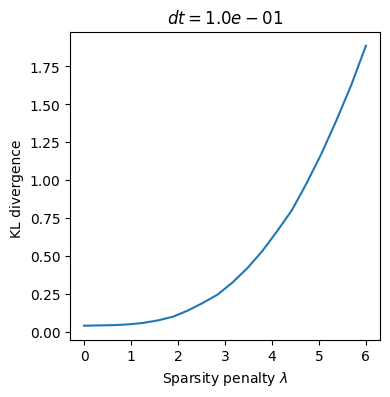

In [51]:
fig,ax = plt.subplots(figsize=(4,4))

ax.plot(sparsity_pentalty_list,kl_values)
ax.set_xlabel(r'Sparsity penalty $\lambda$')
ax.set_ylabel(r'KL divergence ')
ax.set_title(r'$dt=%.1e$'%(dt))

In [46]:
dt

0.1

In [65]:
# sweep through dt values

dt_list = 10.**np.linspace(-4,0,6)
sparsity_pentalty_list = np.arange(6)
tmax = int(1e5)
vmax=3
n_bins=100

kl_values_dt_sp = np.empty([len(dt_list),len(sparsity_pentalty_list)])

for j in tqdm(range(len(dt_list))):
    for k in range(len(sparsity_pentalty_list)):

        lsc.set_dt(dt_list[j])
        lsc.sparsity_penaly = sparsity_pentalty_list[k]

        s_inference = torch.ones_like(s_star) #Change to L0
        # s_inference = th.zeros_like(s) #Change to L0
        energies = []
        S = []
        S.append(s_inference.data.numpy().copy())
        for n in (range(tmax)):

            energies.append(lsc.energy(x,s_inference).item())
            s_inference += torch.clone(lsc.first_order_langevin_update(x,s_inference))
            S.append(s_inference.data.numpy().copy())
        S = np.asarray(S)
        energies = np.asarray(energies)

        # compute true pdf
        xlist = np.linspace(-vmax, vmax, n_bins)
        ylist = np.linspace(-vmax, vmax, n_bins)
        X, Y = np.meshgrid(xlist, ylist)
        Sgrid = np.asarray([X.flatten(),Y.flatten()]).T

        Z = np.zeros([Sgrid.shape[0]])
        for i in range(len(Z)):
            Z[i] = lsc.p(x,torch.tensor(Sgrid[i,:],dtype=torch.float))
        pS_energy_function = Z.reshape(X.shape)
        pS_energy_function /= np.sum(pS_energy_function)

        # compute emperical pdf
        pS_emperical, xedges, yedges = np.histogram2d(
            x=S[:,0],
            y=S[:,1],
            bins=n_bins,
            range=[[-vmax, vmax], [-vmax, vmax]],
            density=True,
        )
        pS_emperical = pS_emperical.T
        pS_emperical /= np.sum(pS_emperical)

        kl_values_dt_sp[j,k] = KLDivergence(pS_emperical.flatten(),pS_energy_function.flatten())

100%|██████████| 6/6 [02:18<00:00, 23.14s/it]


Text(0.5, 1.0, '$\\lambda=6.0$')

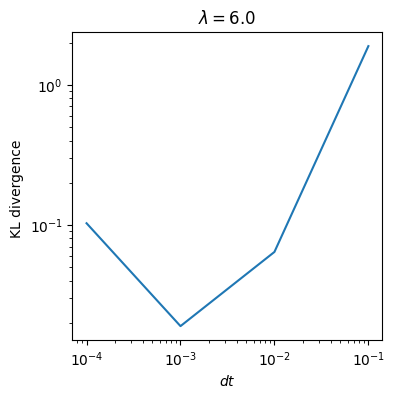

In [58]:
fig,ax = plt.subplots(figsize=(4,4))

ax.loglog(dt_list,kl_values_dt)
ax.set_xlabel(r'$dt$')
ax.set_ylabel(r'KL divergence ')
ax.set_title(r'$\lambda=%.1f$'%(lsc.sparsity_penaly))

Text(0.5, 1.0, 'First order; $T=1.0$; 1e+05 samples')

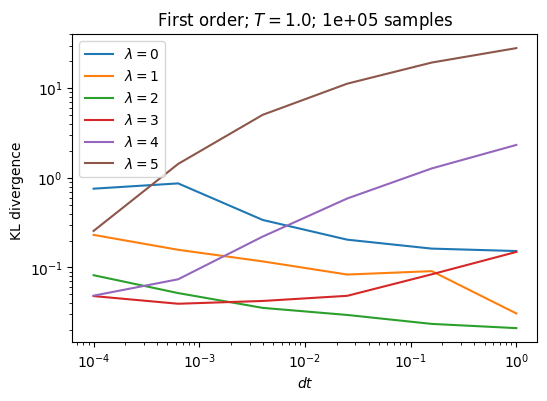

In [66]:
fig,ax = plt.subplots(figsize=(6,4))

for k in range(len(sparsity_pentalty_list)):
    ax.loglog(dt_list,kl_values_dt_sp[k,:],label=r'$\lambda=%d$'%(sparsity_pentalty_list[k]))
ax.set_xlabel(r'$dt$')
ax.set_ylabel(r'KL divergence ')
ax.legend()
ax.set_title(r'First order; $T=%.1f$; %.0e samples'%(temperature,tmax))

* The higher the sparsity penalty, the lower $dt$ should be
* the lower $dt$, more samples is probably better

In [37]:
dt_list

array([0.0001, 0.001 , 0.01  , 0.1   ])